**Project 1: Hate Speech Identification**


This script contains both the data cleaning and analysis for our project. Please note that because of the nature of our dataset being focused on hate speech, hateful words are present in both the data and output graphs. While they are censored in other aspects of this project, we were unable to censor them in this script

Data Cleaning:

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#DATA CLEANING:
import numpy as np
import pandas as pd

# 1) Load the dataset
path = PATH  # from the upload cell above
df = pd.read_csv(path, encoding="utf-8", low_memory=False)

# dropping first column
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# 2) Keep only rows with exactly 3 annotators
if "count" not in df.columns:
    raise ValueError("Expected a 'count' column in the dataset.")
df3 = df[df["count"] == 3].copy()

# 3) Keep rows where all three annotators agreed (one of the columns == 3)
for col in ["hate_speech", "offensive_language", "neither"]:
    if col not in df3.columns:
        raise ValueError(f"Expected '{col}' column in the dataset.")
agreement_mask = (
    (df3["hate_speech"] == 3)
    | (df3["offensive_language"] == 3)
    | (df3["neither"] == 3)
)
df_clear = df3[agreement_mask].copy()

# 4) Ensure class column is consistent or derive it from unanimous labels
def derive_class(row):
    if row["hate_speech"] == 3:
        return 0  # hate speech
    elif row["offensive_language"] == 3:
        return 1  # offensive language
    elif row["neither"] == 3:
        return 2  # neither
    return np.nan

if "class" not in df_clear.columns:
    df_clear["class"] = df_clear.apply(derive_class, axis=1)
else:
    df_clear.loc[:, "class"] = df_clear.apply(derive_class, axis=1)

# 5) Drop the count column (optional)
df_clean = df_clear.drop(columns=["count"])

# 6) Save the cleaned dataset
df_clean.to_csv("labeled_data_clean.csv", index=False)

print("✅ Cleaned dataset saved as labeled_data_clean.csv")
print(df_clean["class"].value_counts(dropna=False))
df_clean.head()

✅ Cleaned dataset saved as labeled_data_clean.csv
class
1    13306
2     2753
0      261
Name: count, dtype: int64


,hate_speech,offensive_language,neither,class,tweet
0,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
6,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...


Exploratory Data Analysis

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# ---------- 0) Config ----------
RAW_PATH = "labeled_data.csv"              # path to your raw file
SAVE_CLEAN = True                          # save cleaned CSV
CLEAN_PATH = "labeled_data_clean.csv"
RANDOM_STATE = 123
sns.set(style="whitegrid", context="talk")


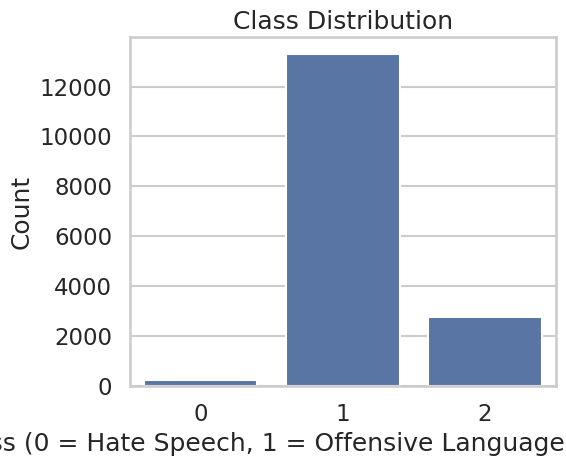

In [ ]:
# plot 1: Class Distribution
plt.figure(figsize=(6,5))
ax = sns.countplot(x="class", data=df_clean)
ax.set_xlabel("Class (0 = Hate Speech, 1 = Offensive Language, 2 = Neither)")
ax.set_ylabel("Count")
ax.set_title("Class Distribution")
plt.tight_layout()

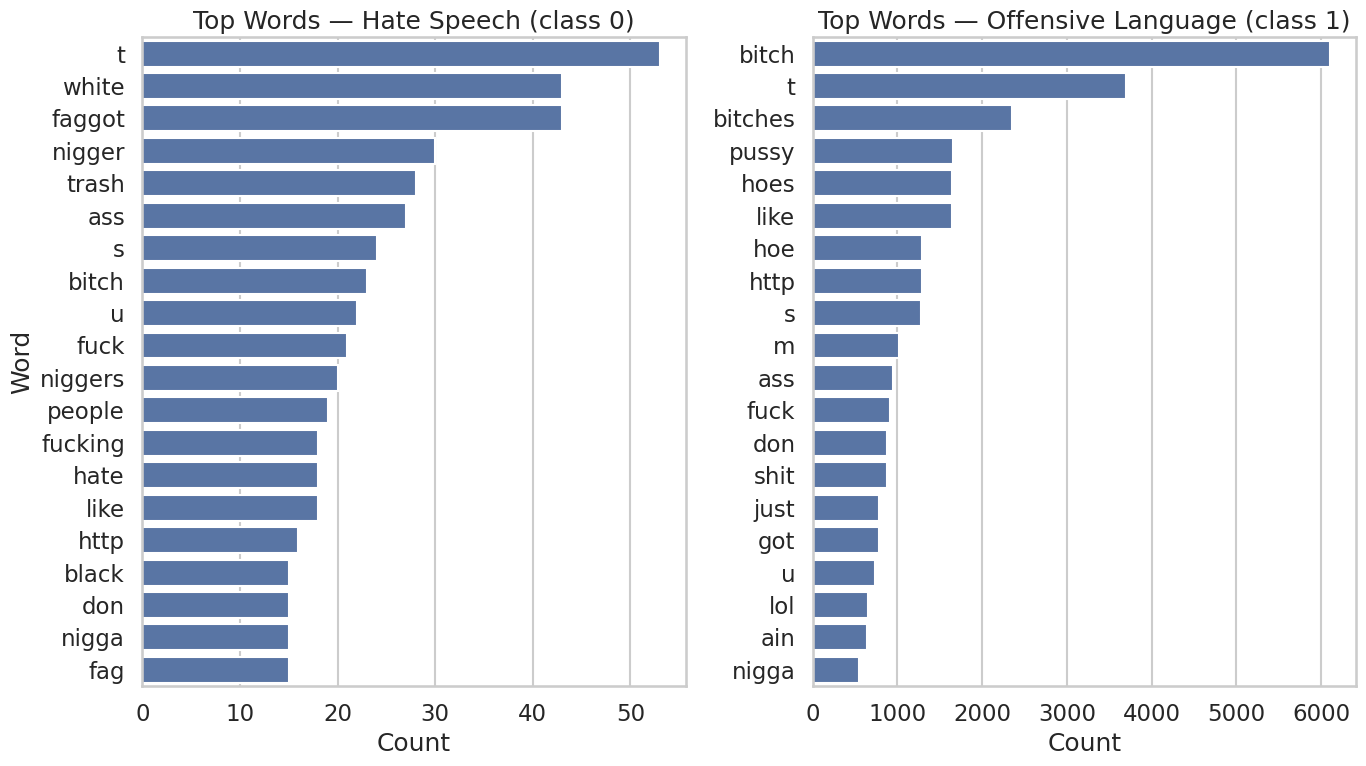

In [ ]:
# plot 2: Top Word Counts
STOPWORDS = set(ENGLISH_STOP_WORDS) | {"rt", "amp"}  # add twitter-ish tokens

def tokenize(text):
    # lowercase, keep words (alphanumeric + underscore)
    toks = re.findall(r"\b\w+\b", text.lower())
    # drop tokens that are only digits or in stopwords
    toks = [t for t in toks if not t.isdigit() and t not in STOPWORDS]
    return toks

def top_words(text_series, n=20):
    tokens = []
    for t in text_series.astype(str):
        tokens.extend(tokenize(t))
    counts = Counter(tokens)
    return pd.DataFrame(counts.most_common(n), columns=["word", "count"])

# split classes
hate_texts = df_clean[df_clean["class"] == 0]["tweet"]
off_texts  = df_clean[df_clean["class"] == 1]["tweet"]

hate_top = top_words(hate_texts, n=20)
off_top  = top_words(off_texts,  n=20)

# side-by-side barplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
sns.barplot(data=hate_top, x="count", y="word", ax=axes[0])
axes[0].set_title("Top Words — Hate Speech (class 0)")
axes[0].set_xlabel("Count"); axes[0].set_ylabel("Word")

sns.barplot(data=off_top, x="count", y="word", ax=axes[1])
axes[1].set_title("Top Words — Offensive Language (class 1)")
axes[1].set_xlabel("Count"); axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

Saved: top_words_hate_over_off.csv, top_words_off_over_hate.csv


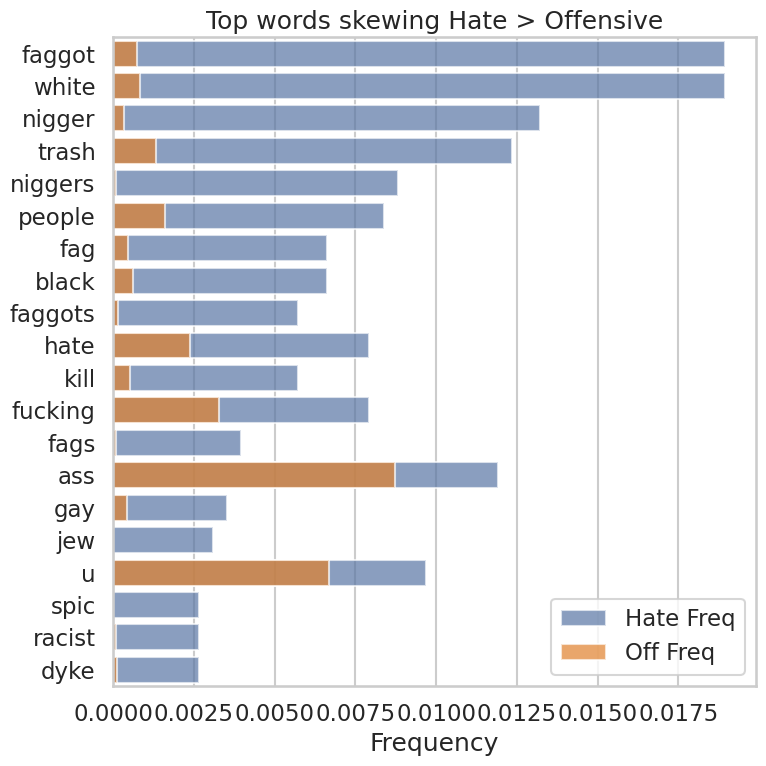

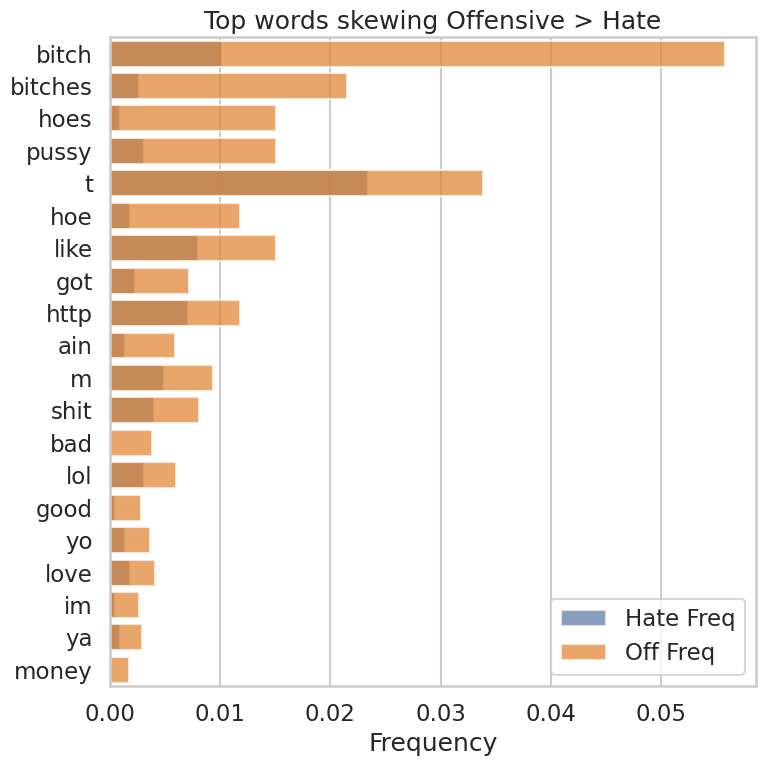

In [ ]:
# Plot 3: word frequency analysis
STOP = set(ENGLISH_STOP_WORDS) | {"rt", "amp"}  # add twitter-ish tokens

def tokenize(text):
    toks = re.findall(r"\b\w+\b", text.lower())
    return [t for t in toks if not t.isdigit() and t not in STOP]

def top_words(series, n=20):
    counts = Counter()
    for t in series:
        counts.update(tokenize(t))
    return pd.DataFrame(counts.most_common(n), columns=["word","count"])

hate = df_clean[df_clean["class"] == 0]["tweet"]
off  = df_clean[df_clean["class"] == 1]["tweet"]
nei  = df_clean[df_clean["class"] == 2]["tweet"]

# frequency tables
hate_counts = Counter([w for t in hate for w in tokenize(t)])
off_counts  = Counter([w for t in off  for w in tokenize(t)])

# combined frequency diff table
words = set(hate_counts) | set(off_counts)
rows = []
hate_total = sum(hate_counts.values()) or 1
off_total  = sum(off_counts.values()) or 1
for w in words:
    hc = hate_counts[w]
    oc = off_counts[w]
    hf = hc / hate_total
    of = oc / off_total
    diff = hf - of             # >0 => skews hate; <0 => skews offensive
    ratio = (hf + 1e-9) / (of + 1e-9)
    rows.append((w, hc, oc, hf, of, diff, ratio))
freq_df = pd.DataFrame(rows, columns=["word","hate_count","off_count","hate_freq","off_freq","freq_diff","freq_ratio"])
freq_df.sort_values("freq_diff", ascending=False).head(25).to_csv("top_words_hate_over_off.csv", index=False)
freq_df.sort_values("freq_diff", ascending=True).head(25).to_csv("top_words_off_over_hate.csv", index=False)
print("Saved: top_words_hate_over_off.csv, top_words_off_over_hate.csv")

# quick plots of the top 20 distinguishing words per side
def barplot_top(df_sub, title):
    plt.figure(figsize=(8,8))
    sns.barplot(data=df_sub, x="hate_freq", y="word", label="Hate Freq", alpha=0.7)
    sns.barplot(data=df_sub, x="off_freq",  y="word", label="Off Freq", alpha=0.7, color="tab:orange")
    plt.legend()
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

barplot_top(freq_df.sort_values("freq_diff", ascending=False).head(20), "Top words skewing Hate > Offensive")
barplot_top(freq_df.sort_values("freq_diff", ascending=True).head(20),  "Top words skewing Offensive > Hate")

Analysis and Modeling:

VADER Analysis

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Saved: sentiment_summary_by_class.csv
            neg                               neu                          \
           mean median       std  count      mean median       std  count   
class                                                                       
0      0.290893  0.281  0.231636    261  0.648471  0.637  0.230802    261   
1      0.266070  0.264  0.200650  13306  0.639633  0.631  0.207114  13306   
2      0.061550  0.000  0.112813   2753  0.830401  0.844  0.164431   2753   

            pos                          compound                           
           mean median       std  count      mean  median       std  count  
class                                                                       
0      0.060644    0.0  0.103726    261 -0.409708 -0.5719  0.453484    261  
1      0.094296    0.0  0.127670  13306 -0.333923 -0.5267  0.462047  13306  
2      0.108052    0.0  0.142384   2753  0.095741  0.0000  0.403498   2753  


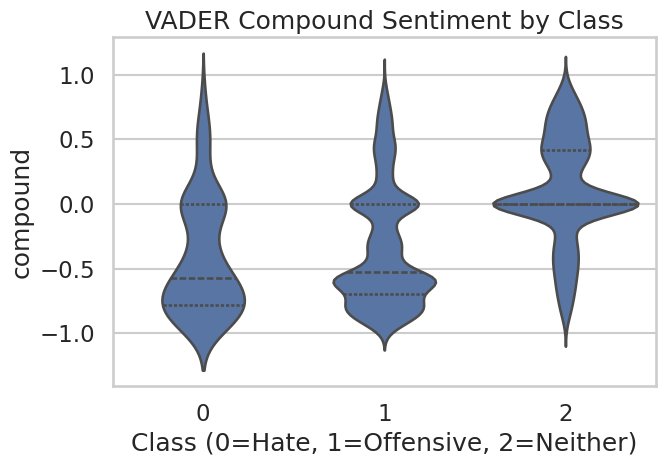

In [ ]:
# VADER (Valence Aware Dictionary for Sentiment Reasoning) baseline analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
try:
    _ = nltk.data.find("sentiment/vader_lexicon.zip")
except LookupError:
    nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    s = sia.polarity_scores(text or "")
    return pd.Series({"neg": s["neg"], "neu": s["neu"], "pos": s["pos"], "compound": s["compound"]})

sent_df = df_clean[["tweet","class"]].copy()
sent_df = pd.concat([sent_df, sent_df["tweet"].apply(sentiment_scores)], axis=1)

# Aggregate by class
sent_summary = sent_df.groupby("class")[["neg","neu","pos","compound"]].agg(["mean","median","std","count"])
sent_summary.to_csv("sentiment_summary_by_class.csv")
print("Saved: sentiment_summary_by_class.csv")
print(sent_summary)

# Plot distributions (compound)
plt.figure(figsize=(7,5))
sns.violinplot(data=sent_df, x="class", y="compound", inner="quartile")
plt.title("VADER Compound Sentiment by Class")
plt.xlabel("Class (0=Hate, 1=Offensive, 2=Neither)")
plt.tight_layout()
plt.show()


Logistic Regression:

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.9679
F1 (macro): 0.6788
F1 (weighted): 0.9719

Classification Report (0=Hate, 1=Offensive):
               precision    recall  f1-score   support

     Hate (0)       0.30      0.50      0.37        52
Offensive (1)       0.99      0.98      0.98      2662

     accuracy                           0.97      2714
    macro avg       0.64      0.74      0.68      2714
 weighted avg       0.98      0.97      0.97      2714



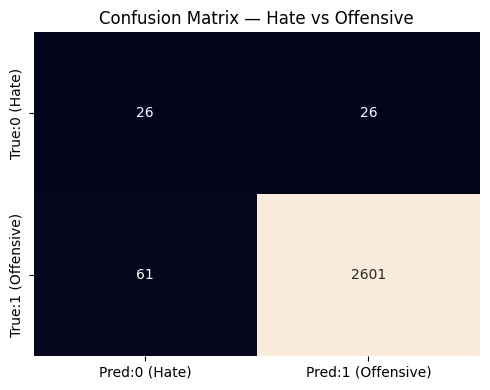

In [ ]:
# Logistic Regression (0 = Hate, 1 = Offensive) + TF-IDF + Confusion Matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- config ---
RANDOM_STATE = 42
TEXT_COL = "tweet"
LABEL_COL = "class"

# Optional: simple tokenizer fallback (remove if you already have one)
def tokenize(s):
    return s.split()

# --- subset to binary classes ---
df_bin = df_clean[df_clean[LABEL_COL].isin([0, 1])].copy()
X_raw = df_bin[TEXT_COL].astype(str).values
y = df_bin[LABEL_COL].values

# --- split FIRST (avoid leakage) ---
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# --- TF-IDF (fit on train only, transform both) ---
vectorizer = TfidfVectorizer(
    lowercase=True,
    tokenizer=tokenize,     # replace/remove if you prefer default token_pattern
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)
X_train = vectorizer.fit_transform(X_train_raw)
X_test  = vectorizer.transform(X_test_raw)

# --- train ---
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)

# --- evaluate ---
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {acc:.4f}")
print(f"F1 (macro): {f1_macro:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}\n")

print("Classification Report (0=Hate, 1=Offensive):")
print(classification_report(y_test, y_pred, target_names=["Hate (0)", "Offensive (1)"]))

# --- confusion matrix heatmap ---
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cbar=False,
    xticklabels=["Pred:0 (Hate)", "Pred:1 (Offensive)"],
    yticklabels=["True:0 (Hate)", "True:1 (Offensive)"]
)
plt.title("Confusion Matrix — Hate vs Offensive")
plt.tight_layout()
plt.show()


BERT:

In [ ]:
# Runtime > Change runtime type > GPU recommended
!pip -q install transformers==4.44.2 datasets==2.21.0 evaluate==0.4.2 accelerate==0.34.2 scikit-learn==1.5.2 matplotlib seaborn

import torch
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
from google.colab import files
up = files.upload()  # choose labeled_data.csv
PATH = next(iter(up.keys()))
print("Using:", PATH)

GPU available: False


Saving labeled_data.csv to labeled_data (1).csv
Using: labeled_data (1).csv
